# Use XGBoost to train the data

- Ref 1: https://www.datacamp.com/tutorial/xgboost-in-python
- Ref 2: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.pylab as pl

shap.initjs()

# Load and preprocess the data

In [2]:
MA_AP_all_data = pd.read_excel('data/MA_AP_performance/AP_data_combined_18_22.xlsx', sheet_name='2018-22')    ## load all five-year data
data_MA_inference = MA_AP_all_data.drop(columns=['District Name', 'District Code', 'Year', 'Tests Taken'])    ## drop unnecessary columns
data_MA_inference.columns    ## print all column names

Index(['% Score 3-5', 'Population', 'Median Household Income',
       'Total Expenditures per Pupil', 'Shortest Distance to R1R2',
       'Number of Annual Enrollment R1R2', 'Number of Dorm Beds R1R2',
       'Shortest Distance to Public', 'Number of Annual Enrollment Public',
       'Number of Dorm Beds Public', 'Shortest Distance to Private',
       'Number of Annual Enrollment Private', 'Number of Dorm Beds Private',
       'Shortest Distance to Land Grant',
       'Number of Annual Enrollment Land Grant',
       'Number of Dorm Beds Land Grant', 'Shortest Distance to STEM',
       'Number of Annual Enrollment STEM', 'Number of Dorm Beds STEM'],
      dtype='object')

# Split the full data set into the train set and the test set

In [3]:
outcome  = data_MA_inference.columns[0]       ## use the column '% Score 3-5' as the outcome of the model
features = data_MA_inference.columns[1:]      ## all other columns are the features of the model

X = data_MA_inference[features]
y = data_MA_inference[outcome]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=216)

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Use XGBoost to train the model

In [4]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)

[0]	train-rmse:13.97433	validation-rmse:14.92895
[10]	train-rmse:6.01349	validation-rmse:8.29550
[20]	train-rmse:4.61445	validation-rmse:8.20733
[30]	train-rmse:3.64537	validation-rmse:8.28773
[40]	train-rmse:3.06651	validation-rmse:8.44068
[50]	train-rmse:2.53566	validation-rmse:8.49510
[60]	train-rmse:2.18580	validation-rmse:8.52753
[70]	train-rmse:1.86667	validation-rmse:8.58356
[80]	train-rmse:1.62306	validation-rmse:8.59846
[90]	train-rmse:1.47577	validation-rmse:8.63348
[100]	train-rmse:1.31188	validation-rmse:8.66251
[110]	train-rmse:1.20650	validation-rmse:8.69689
[114]	train-rmse:1.18048	validation-rmse:8.69549


# Example: use the ``xgb_model`` trained above for predicting AP outcomes

In [5]:
# Example: New data to predict
X_new = data_MA_inference[features].head(3)  ## just use the old data as a quick example

# Create a DMatrix for the new data
dnew_reg = xgb.DMatrix(X_new, enable_categorical=True)

# Make predictions
y_pred_new = xgb_model.predict(dnew_reg)

print('Predictions for new percentage of AP outcomes that scores 3-5:')
print(y_pred_new)

Predictions for new percentage of AP outcomes that scores 3-5:
[53.59611  58.337765 79.06966 ]


# Next, I want to know the accuracy of the trained model

### XGBoost Cross-Validation

In [6]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=100
)

results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,13.915723,0.117049,14.339408,0.434560
1,11.475337,0.126982,12.340381,0.480862
2,9.863191,0.136914,11.130190,0.582571
3,8.715333,0.110801,10.351080,0.605964
4,7.931407,0.071191,9.854446,0.661094


In [7]:
mean_train_rmse = results['train-rmse-mean'].iloc[-1]  # Final mean train RMSE
std_train_rmse = results['train-rmse-std'].iloc[-1]    # Final std dev train RMSE

mean_val_rmse = results['test-rmse-mean'].iloc[-1]     # Final mean validation RMSE
std_val_rmse = results['test-rmse-std'].iloc[-1]       # Final std dev validation RMSE

# Print results
print(f"Training RMSE: {mean_train_rmse:.4f} +/- {std_train_rmse:.4f}")
print(f"Validation RMSE: {mean_val_rmse:.4f} +/- {std_val_rmse:.4f}")

Training RMSE: 5.8865 +/- 0.2022
Validation RMSE: 9.3043 +/- 0.6643


# Use SHAP values to make plots

### Setting up SHAP Explainer

In [7]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

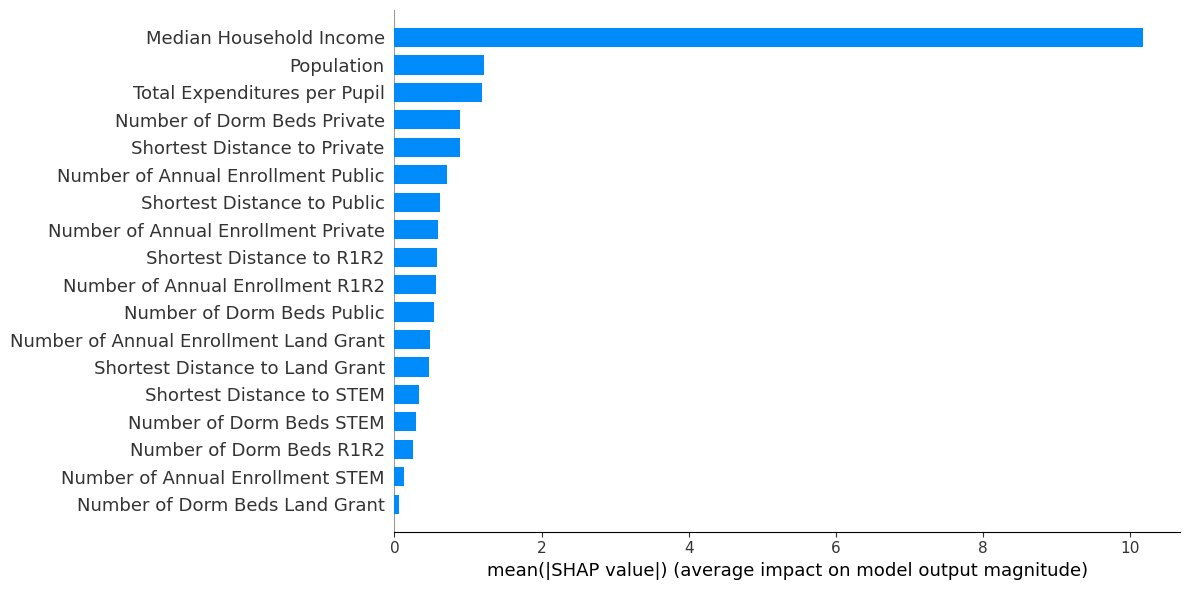

In [13]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
# Save the plot to a file
plt.savefig('data/MA_AP_performance/plot/xgboost/shap_summary_plot_bar.png', bbox_inches='tight')
plt.show()
plt.close()

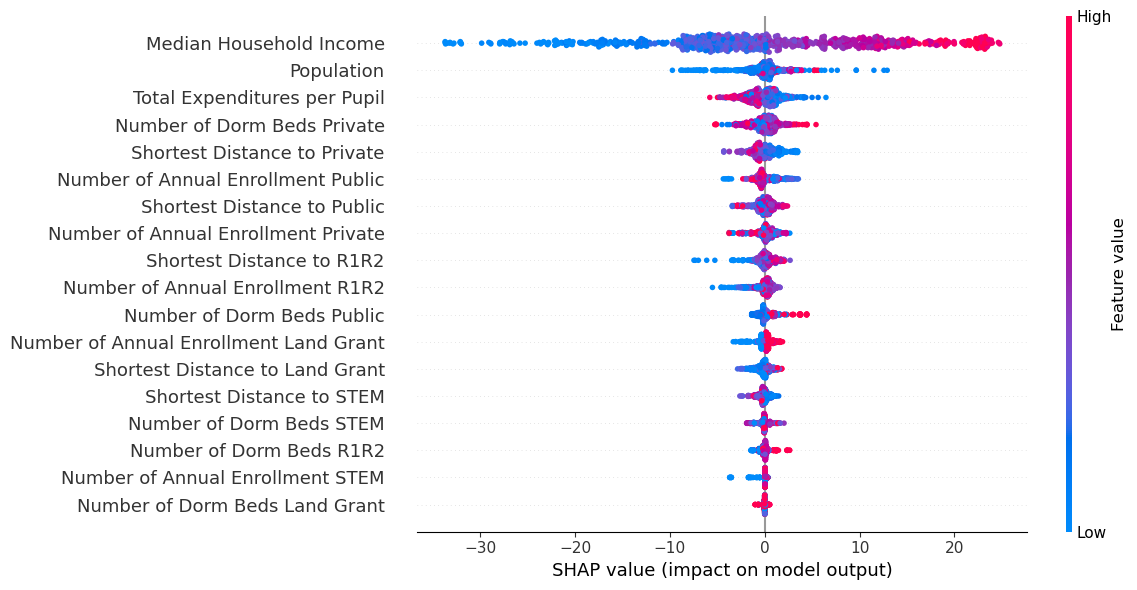

In [14]:
### the scatter plot
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.savefig('data/MA_AP_performance/plot/xgboost/shap_summary_plot_density_scatter.png', bbox_inches='tight')
plt.show()
plt.close()

# Use the SHAP explainer and values from the summary plot setup

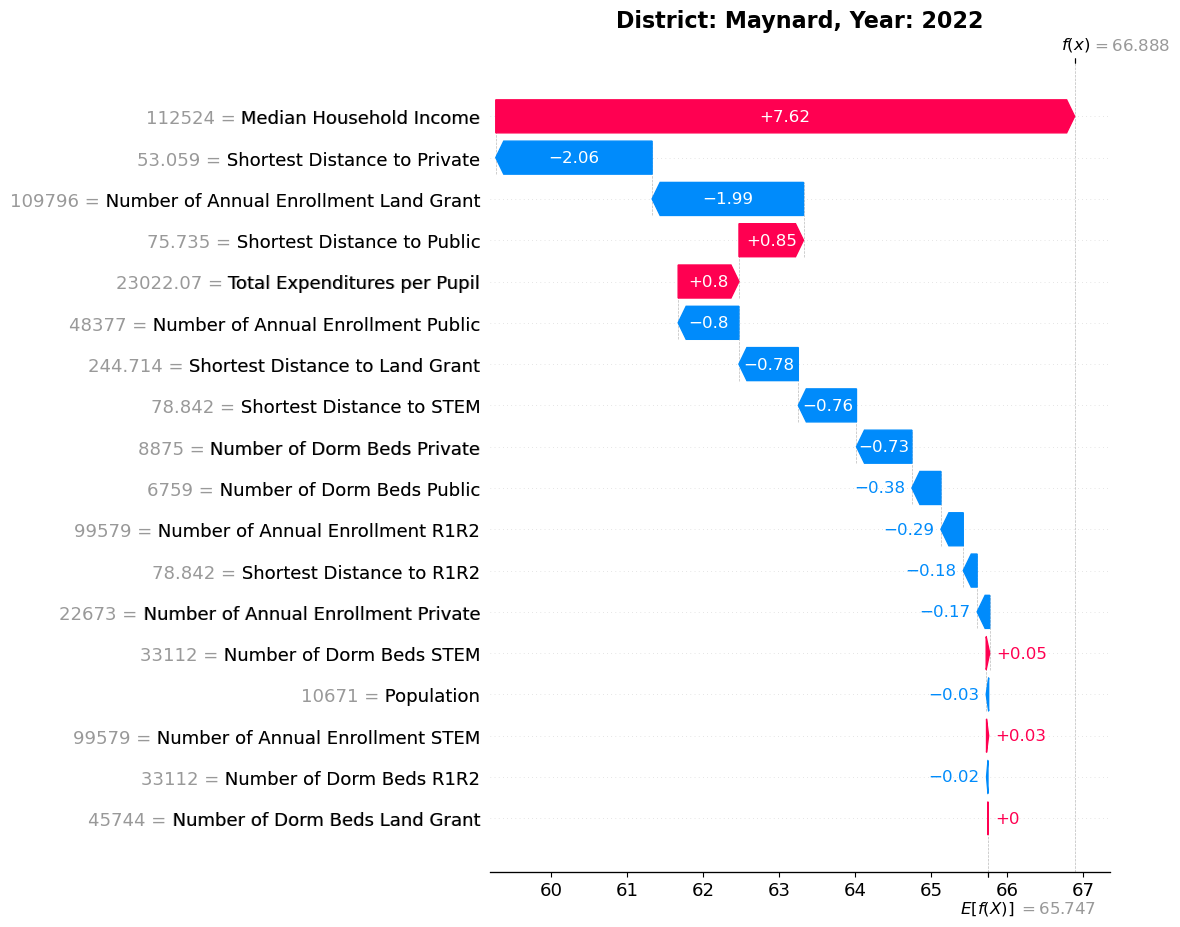

In [10]:
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_train)

## sample_index is variable
sample_index = 0

shap_sample = shap.Explanation(
    values=shap_values[sample_index].values,
    base_values=shap_values[sample_index].base_values,
    data=X_test.iloc[sample_index],
    feature_names=X_test.columns
)

## get the district name and year of this sample_index
district_name, data_year = MA_AP_all_data.iloc[int(X_test.index[sample_index])][['District Name', 'Year']].tolist()
data_year = int(data_year)

fig = plt.figure()
shap.waterfall_plot(shap_sample, max_display=18, show=False)  # Generate the SHAP waterfall plot
plt.title(f"District: {district_name}, Year: {data_year}", fontsize=16, weight='bold')
fig.savefig('data/MA_AP_performance/plot/xgboost/shap_summary_waterfall.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)

# Visualize a single prediction

In [12]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

In [13]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# Visualize many predictions

In [14]:
shap.force_plot(explainer.expected_value, shap_values[:X_test.shape[0], :], X_test.iloc[:X_test.shape[0], :])

# SHAP Dependence Plots

In [11]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

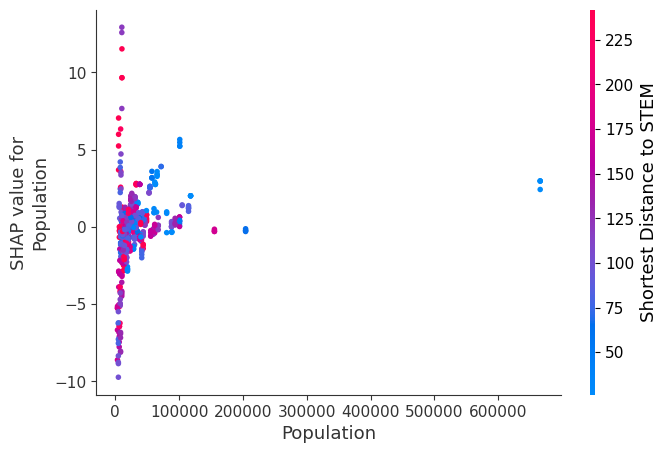

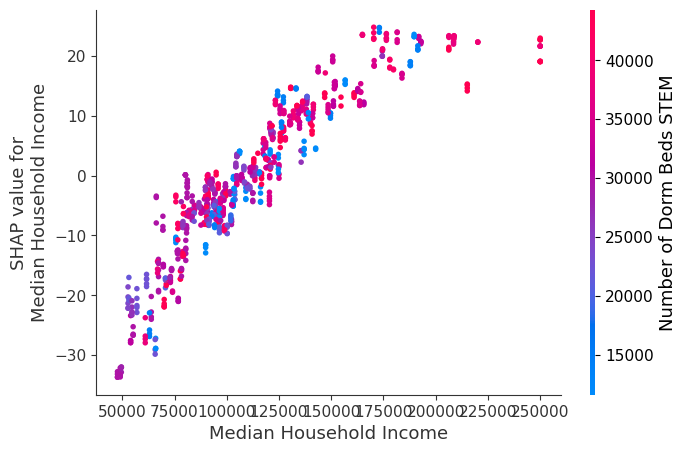

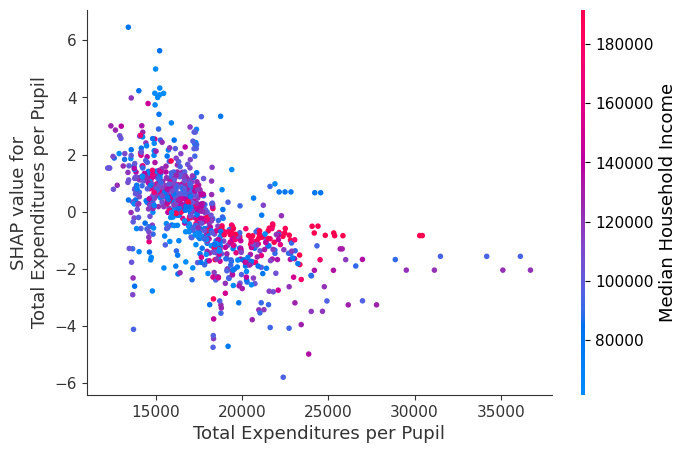

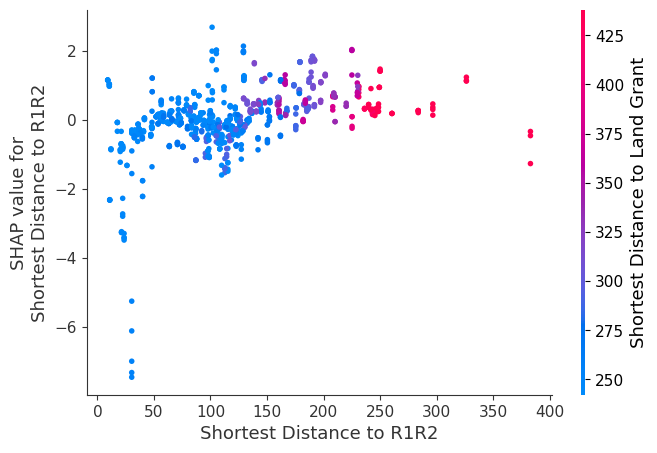

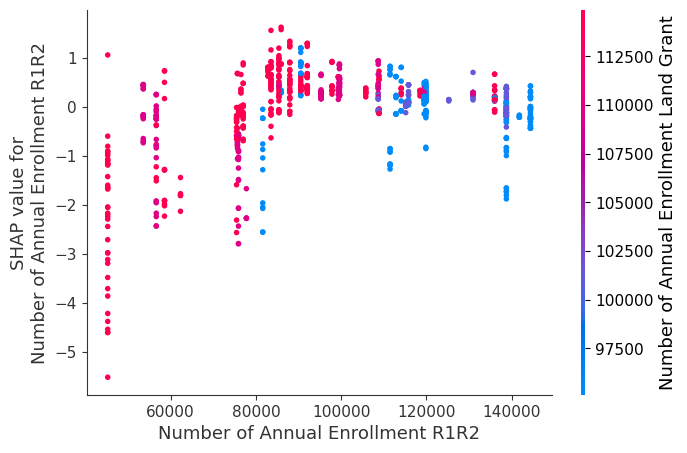

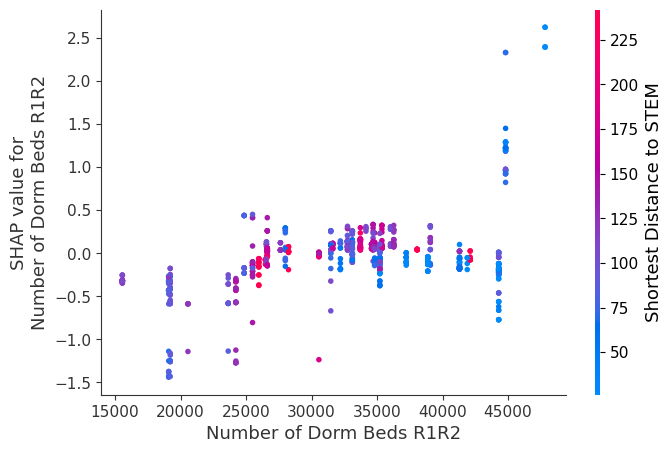

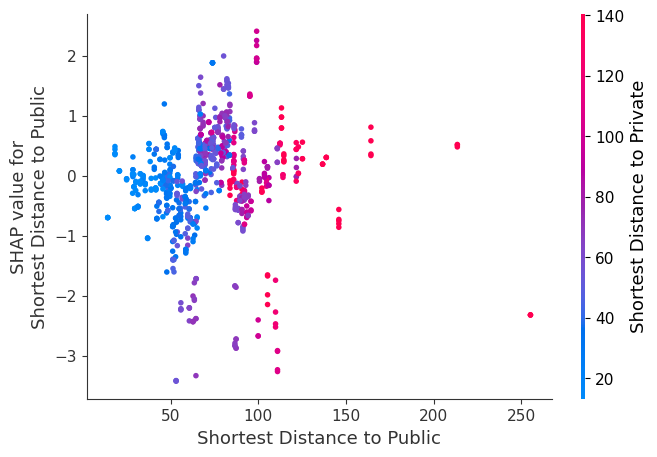

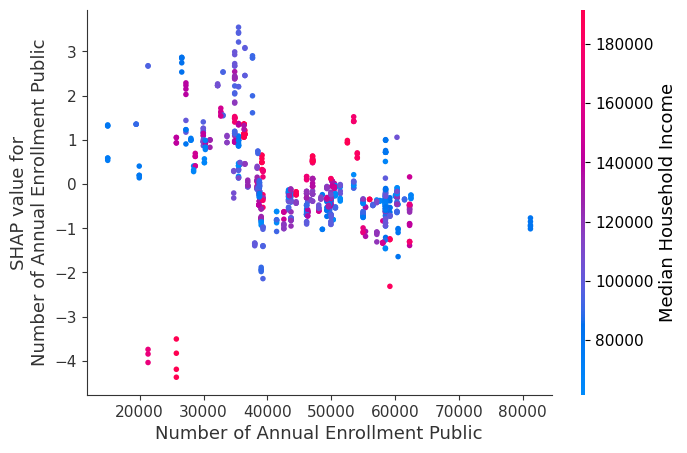

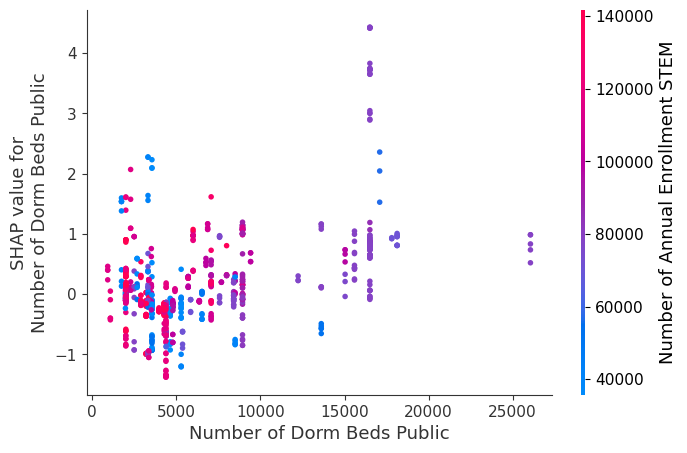

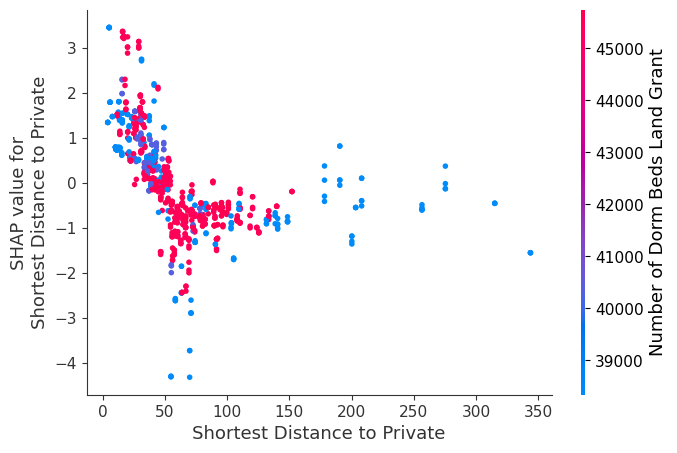

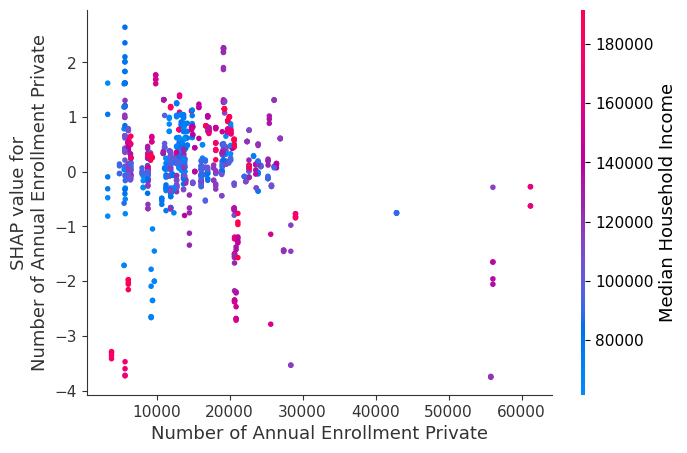

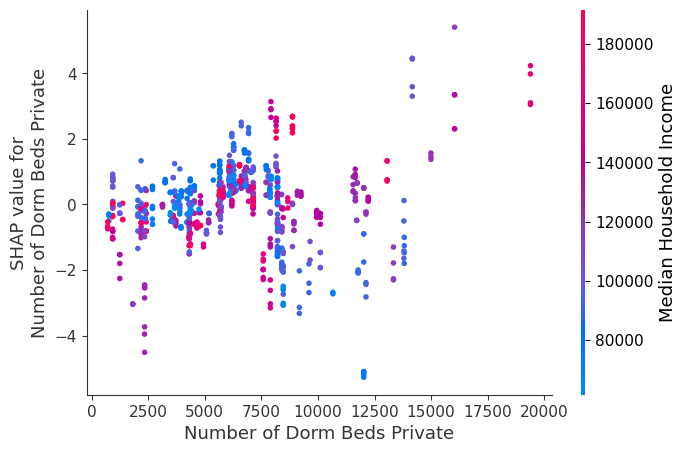

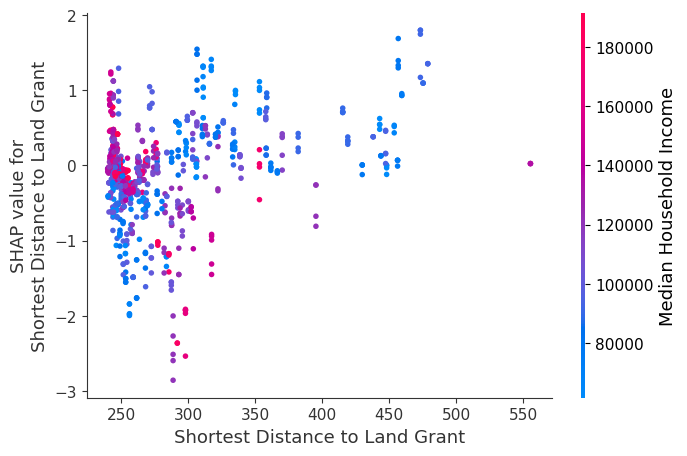

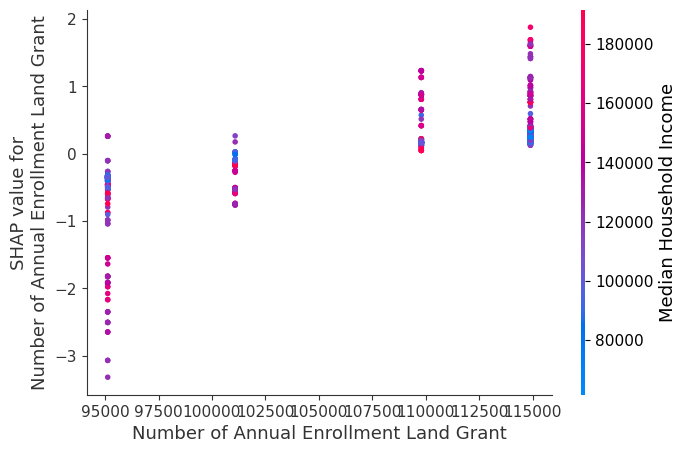

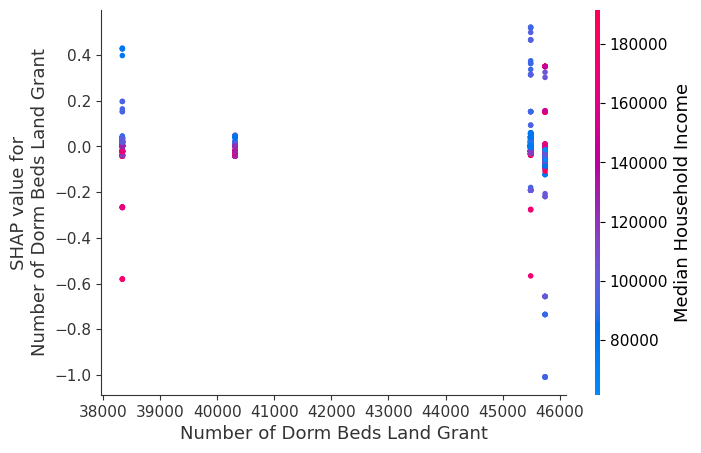

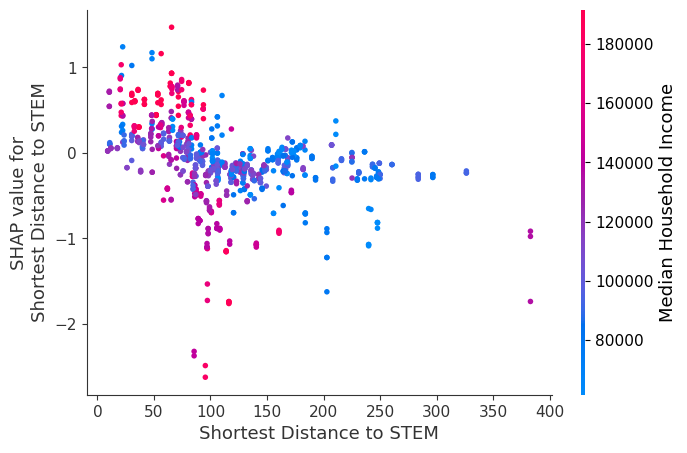

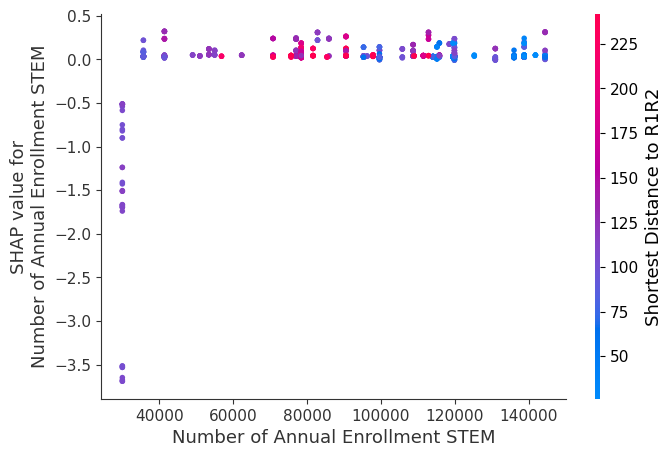

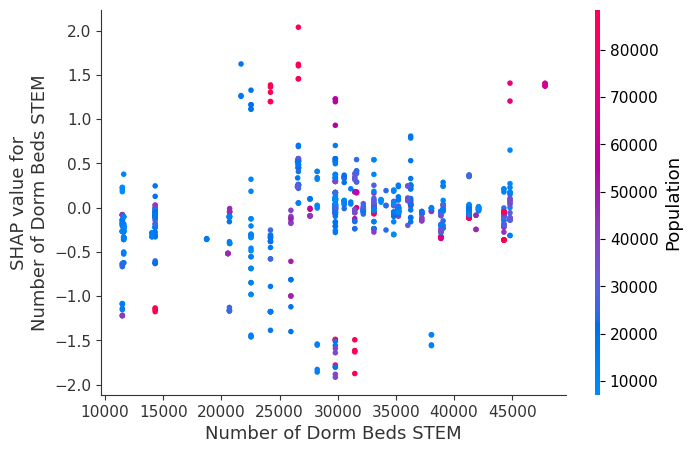

In [12]:
for name in X.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train, show=False)
    plt.savefig('data/MA_AP_performance/plot/xgboost/shap_dependence_%s.pdf'%(name), bbox_inches='tight')
    plt.show()
    plt.close()